### Application of $\chi^2$ on ASCAD

On a per-sample-point basis.

In [100]:
import math
from random import choices

import numpy as np
import seaborn as sns
from tqdm import tqdm

from tools.cache import cache_np
from tools.nbloader import NotebookLoader
from tools.plotter import shadow_plot, line_plot_poi
from tools.poi import select_poi
from tools.traceloader import ASCAD, TraceGroup
from IPython.display import Markdown as md

sns.set_style("whitegrid")

In [101]:
TABLE_SIZE = 64

ascad = ASCAD()
ascad.default.profile.traces.shape

(200000, 1400)

importing Jupyter notebook from ../tvla/chi2.ipynb


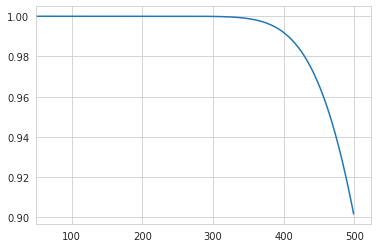

In [102]:
chi_squared = NotebookLoader(["../tvla"]).load_module("chi2").chi_squared_balanced

In [103]:
def count_sample_point(traces: np.array):
    """
    Simple contingency table creation function that counts occurrences of a power trace value ([0..256] for ASCAD)
    per sample point.

    Used as a reference function, as count(..., window_size = 1) yields the same result.
    """
    return np.array([np.bincount(t, minlength=ASCAD.key_size) for t in np.moveaxis(traces, 0, -1) + (-ASCAD.offset)],
                    dtype=np.uint32)

def reduce_ctable(bin_count: np.array, size_from: int, size_to: int):
    """
    Reduces the size of a given contingency table.
    """
    res = np.zeros(size_to, dtype=np.uint32)
    step = round(size_from / size_to) # Should be divisible

    for ix in range(size_to):
        res[ix] = np.sum(bin_count[ix * step:(ix + 1) * step])

    return res

def count(traces: np.array, window_size, table_size=TABLE_SIZE):
    """
    Creates a contingency table counting the occurrences of a power trace value ([0..256] for ASCAD) per sliding
    window step.

    @param traces: Array of traces.
    @param window_size: The sliding window size. The window step is fixed to 1.
    @param table_size: The size of the resulting contingency table.
    """
    traces_norm = np.moveaxis(traces, 0, -1) + (-ASCAD.offset)
    trace_size = traces_norm.shape[0]

    max_win_ix = trace_size - window_size + 1
    res = np.array([np.zeros(table_size)] * max_win_ix, dtype=np.uint32)

    for ix in range(max_win_ix):
        # Count using the original contingency table.
        orig_table = np.zeros(ASCAD.key_size)
        for t in traces_norm[ix:ix + window_size]:
            orig_table += np.array(np.bincount(t, minlength=ASCAD.key_size), dtype=np.uint32)

        # Reduce the size of the contingency table, so chi^2 will be able to handle it.
        res[ix] = reduce_ctable(orig_table, ASCAD.key_size, table_size)

    return res


# The sum of bin counts with window = 1 should be equal to the sample-point bin count.
assert count(ascad.default.profile.filter_traces(0), 1).sum() - \
       count_sample_point(ascad.default.profile.filter_traces(0)).sum() == 0

In [109]:
def balance_count(traces, sw_size, max_len=None):
    """
    Balances the sum of trace contingency tables by randomly incrementing counters using the existing distribution from
    each underrepresented table.

    Useful when dealing with trace sets that are not of the same size.
    """
    num_traces, _ = traces.shape

    split = fill = round(num_traces / 2)
    if max_len is None:
        # If the trace length to be matched is given.
        fill = math.ceil(num_traces / 2)

    cnt = lambda a: count(a, sw_size)
    left, right = cnt(traces[split:]), cnt(traces[:split])

    num_wins, num_bins = left.shape
    cs = lambda w, k: choices(list(range(num_bins)), weights=w, k=k)

    # Get the number of draws per sliding window index.
    draw_left = (fill - (num_traces - split)) * sw_size
    draw_right = (fill - split) * sw_size

    print(draw_left, draw_right)

    for sw_ix in range(num_wins):
        # Pull from existing distribution...
        c_left = cs(left[sw_ix], draw_left)
        c_right = cs(right[sw_ix], draw_right)

        # and add the pulled indexes to the trace counts.
        np.add.at(left[sw_ix], c_left, 1)
        np.add.at(right[sw_ix], c_right, 1)

    return left, right

TMP = [i.sum() for i in balance_count(ascad.default.profile.filter_traces(3), 10)]

# Left and right should be balanced.
assert TMP[1] - TMP[0] == 0

def chi2(tg: TraceGroup, ks, sw_size):
    max_traces = max([len(tg.profile.filter_traces(i)) for i in range(ks)])
    max_window = ASCAD.trace_len - sw_size + 1

    c_left, c_right = [np.zeros(max_window)] * ks, [np.zeros(max_window)] * ks
    for k in tqdm(range(ks), desc="Creating contingency tables   "):
        c_left[k], c_right[k] = balance_count(tg.profile.filter_traces(k), sw_size, max_traces)
        print(c_left[k].sum(), c_right[k].sum())
        raise Exception()

    offset = round(sw_size / 2)

    csp = np.array([[[np.nan] * ASCAD.trace_len] * ks] * ks)
    progress = tqdm(total=(ks ** 2), desc=f"Calculating p-values for keys ")
    for k1 in range(ks):
        for k2 in range(ks):
            for sp in range(max_window):
                try:
                    csp[k1][k2][sp + offset] = chi_squared(c_left[k1][sp], c_right[k2][sp])
                except ValueError as _:
                    csp[k1][k2][sp + offset] = 1

            progress.update(1)

    progress.close()
    return csp

NUM_KEYS = 27
SLIDING_WINDOW_SIZE = 10

cache_chi2 = lambda tg, kb, win_size: cache_np(f"chi2_k{kb}_w{win_size}_ks{NUM_KEYS}",
                                             chi2, tg, NUM_KEYS, win_size)
# C2_K1_SP = cache_chi2(ascad.default, 1, 1)

C2_K1_SW = cache_chi2(ascad.default, 1, SLIDING_WINDOW_SIZE)
C2_K3_SW = cache_chi2(ascad.masked, 3, SLIDING_WINDOW_SIZE)

Creating contingency tables   :   0%|          | 0/27 [00:00<?, ?it/s]


10 0
0 0
5285800 5285800


Exception: 

In [ ]:
sns.lineplot(data=C2_K1_SW[0][0])

In [ ]:
def p_value_mean(ps):
    keys = range(len(ps))
    ps_equal_key = np.array([ps[i][i] for i in keys]).mean(axis=0)
    ps_different_key = np.array([ps[i][j] for i in keys for j in keys if i != j]).mean(axis=0)

    return ps_equal_key, ps_different_key

In [ ]:
def pv_plot(chi2_results, mdiff):
    pv_mean = p_value_mean(chi2_results)

    shadow_plot({
        "Average p-value for equal keys": pv_mean[0],
        "Average p-value for different keys": pv_mean[1]
    }, title="$p$-value for equal keys vs. $p$-value for different keys.\n")

    line_plot_poi({
        "$p$-value mean difference": np.array(pv_mean[0] - pv_mean[1]), # Equal keys - Different keys
        "Sample point mean difference": mdiff[1] # 1st order moment difference
    }, select_poi(mdiff[1]), poi_alpha=.1,
        title="$p$-value difference vs. sample point difference.\n"
              "Points of Interest are highlighted.\n", xlim=(0, 700))

    line_plot_poi({
        "$p$-value mean difference": np.array(pv_mean[0] - pv_mean[1]), # Equal keys - Different keys
        "Sample point mean difference": mdiff[1] # 1st order moment difference
    }, select_poi(mdiff[1]), poi_alpha=.1,
        title="$p$-value difference vs. sample point difference.\n"
              "Points of Interest are highlighted.\n", xlim=(30, 100))

# $\chi^2$-test $p$-value difference

If there is a leakage, traces with equal keys should show dependence and
traces that have different keys should show independence.

Small $p$ values give evidence to reject the null hypothesis and conclude that the observations are not independent.

### $p$-value difference per sample point

In [ ]:
pv_plot(C2_K1_SP, cache_np("mdiff_prof", v=1))

In [ ]:
cache_np("mdiff_prof", v=1)[1].shape

### $p$-value difference per sliding window

In [ ]:
md(f"Sliding window size: ({SLIDING_WINDOW_SIZE}), Sliding window step: (1).")

In [ ]:
pv_plot(C2_K1_SW, cache_np("mdiff_prof", v=1))

In [ ]:
pv_plot(C2_K3_SW, cache_np("mdiff_mask", v=1))

In [ ]:
PVM = np.array(p_value_mean(C2_K3_SW))
MDIFF = cache_np("mdiff_prof", v=1)
line_plot_poi({
        "$p$-value mean difference": np.array(PVM[0] - PVM[1]), # Equal keys - Different keys
        "Sample point mean difference": MDIFF[1] # 1st order moment difference
    }, select_poi(MDIFF[1]), poi_alpha=.1,
        title="$p$-value difference from 3rd key byte vs. sample point difference from 1st key byte.\n"
              "Points of Interest from 1st key byte are highlighted.\n", xlim=(30, 100))